# PROMS Data Processing and Machine Learning

#### *Import packages*

In [1]:
import pandas as pd
import numpy as np
import string
import nltk
import itertools
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import pickle
warnings.filterwarnings("ignore") # "error", "ignore", always", "default", "modlule"

#### *Read CSV*

In [ ]:
proms_data = pd.read_csv("CSV/PROMS_API_EXTRA.csv")
proms_data.head()

#### *Check if there are any empty values*

In [ ]:
proms_data.isnull().sum().sort_values(ascending=False)

## Text cleansing

#### *Clean title and remarks from unecessary characters*

In [ ]:
proms_data.title = proms_data.title.\
    str.lower().\
    str.replace('\d+', ' ').\
    str.replace(r'[[:punct:]]', ' ').\
    str.replace('\r\n', ' ').\
    str.replace('\\b[a-z]\\b', ' ').\
    str.replace('\W+', ' ').\
    str.replace(' +', ' ')

proms_data.remarks = proms_data.remarks.\
    str.lower().\
    str.replace('\d+', ' ').\
    str.replace(r'[[:punct:]]', ' ').\
    str.replace('\r\n', ' ').\
    str.replace('\\b[a-z]\\b', ' ').\
    str.replace('\W+', ' ').\
    str.replace(' +', ' ')

proms_data.head()

#### *Stemming Bahasa*

<b>WARNING!</b> these part of program will run through words one by one to convert each word to its basic form. For each words of the sentences exists in our data will run through the list of dictionary of basic form of Bahasa words. The process would take more than an hour, two hour, or even longer depending on the number data that we possess and the spec of your computer. Pleas uncomment the code to stem the texts when you are ready.


In [5]:
# stemmer_bahasa = StemmerFactory().create_stemmer()
# stemmer_bahasa

# stemmed_title = proms_data.apply(lambda row: stemmer_bahasa.stem(row["title"]), axis=1)
# stemmed_remarks = proms_data.apply(lambda row: stemmer_bahasa.stem(row["remarks"]), axis=1)

# pd.DataFrame(stemmed_title, columns=["title"]).to_csv("stemmed_title.txt", index=False)
# pd.DataFrame(stemmed_remarks, columns=["remarks"]).to_csv("stemmed_remarks.txt", index=False)

*Compare the original and the result of the stemming process*

In [ ]:
print(proms_data.remarks.head())
print(open("TXT/remark_sentences.txt", "r").read().split("\n")[0:5])

*Save the result to the dataframe*

In [7]:
proms_data.title = pd.read_csv("TXT/stemmed_title.txt").title
proms_data.remarks = pd.read_csv("TXT/stemmed_remarks.txt").remarks

*Check for any empty values after text cleansing process*

In [ ]:
proms_data.isnull().sum().sort_values(ascending=False)

In [ ]:
proms_data = proms_data[(proms_data.remarks.isnull() == False) & (proms_data.title.isnull() == False)]
proms_data.isnull().sum().sort_values(ascending=False)

## Machine Learning

#### *Creating prediction target*

The average of Time to Completion, Complexity, and Related Parties parameter should serve as our target for prediction as they are the current measurement of each workload.

In [ ]:
proms_data["target"] = proms_data.time_to_completion + proms_data.complexity + proms_data.related_parties
proms_data = proms_data[proms_data.target != 2]
proms_data.head()

#### *Train and test data*

In [11]:
x_train, x_test, y_train, y_test = train_test_split(proms_data.loc[:, proms_data.columns != "target"], 
proms_data.target, test_size=0.2, random_state=126)

Split total data for training and testing purpose with 80% of the data for training, and the 20% of the data for testing

### *Target data proportion*

<AxesSubplot:xlabel='target', ylabel='count'>

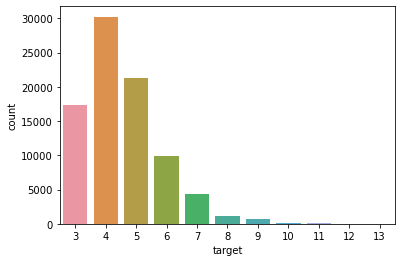

In [12]:
sns.countplot(y_train)

In theory, suppose that we do not balance our data, we could possibly have a problem with our machine learning being used to predict more toward the majority of a population. In this case, when we train our data as where target 1 being the most dominant, and the difference between the highest and the lowest population is high. the probability of a data being predicted as target 1 than target 5 will not be equal, which will then reduce the true accuracy during the actual prediction, when the machine leaning model is deployed.

To counter this problem, a method called oversampling will be used. The oversampling method is a method which duplicate data in a random way from the population that belongs to the minority class. The purpose of oversampling our data would be to create an equal probability of prediction in each target. We should only do oversampling to the training data.

*Balancing target*

<AxesSubplot:xlabel='target', ylabel='count'>

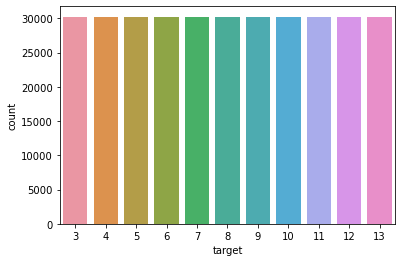

In [13]:
over_sampler = RandomOverSampler(random_state=126)
x_oversampled, y_oversampled = over_sampler.fit_resample(x_train, y_train)
sns.countplot(y_oversampled)

#### *Generate vectorizer*

In [14]:
balanced_vect = CountVectorizer(min_df=5, ngram_range=(1,1)).fit(x_oversampled.remarks)
vect = CountVectorizer(min_df=5, ngram_range=(1,1)).fit(x_train.remarks)

#### *Dimension of the matrix*

In [15]:
print(len(balanced_vect.get_feature_names_out()))
print(len(vect.get_feature_names_out()))

12479
7939


This would be the dimension of our matrix. Should we try to predict data with different size of dimension, the program will reject the data. The CountVectorizer() result would be used to process our text in a way to create any incoming data input in the same way as the training dataset, thus creating the same matrix with the same dimension as the training dataset.

#### *Transform text data into matrix*

In [16]:
balanced_train_vectorized = balanced_vect.transform(x_oversampled.remarks)
remarks_train_vectorized = vect.transform(x_train.remarks)

After we are done with generating vectorizer, we have to transform our text data based on the vector data that we just created

#### *Naive Bayes Model*

In [17]:
model_naive_balanced = MultinomialNB()
model_naive_balanced.fit(balanced_train_vectorized, y_oversampled)

model_naive = MultinomialNB()
model_naive.fit(remarks_train_vectorized, y_train)

MultinomialNB()

#### *Prediction*

To ensure that there are no overfitting or underfitting. it is best to compare the result of train data prediction to the test data prediction. The difference of accuracy of both prediction result will be the determining factor of the overfitting where the value difference should not be too big of a difference. We would also want to ensure that the prediction result of the train data is not lower than the prediction result of the test data, which in this case is a condition called an underfitting.

In [18]:
prediction_balanced = model_naive_balanced.predict(balanced_vect.transform(x_test.remarks))
prediction_balanced_train = model_naive_balanced.predict(balanced_vect.transform(x_oversampled.remarks))
prediction = model_naive.predict(vect.transform(x_test.remarks))
prediction_train = model_naive.predict(vect.transform(x_train.remarks))

In [19]:
print("Accuracy of balanced data:", metrics.accuracy_score(y_test, prediction_balanced))
print("Accuracy of balanced train data:", metrics.accuracy_score(y_oversampled, prediction_balanced_train))
print("Difference", (metrics.accuracy_score(y_test, prediction_balanced) - metrics.accuracy_score(y_oversampled, prediction_balanced_train)) * -100, "\n")

print("Accuracy of non-balanced data:", metrics.accuracy_score(y_test, prediction))
print("Accuracy of non-balanced train data:", metrics.accuracy_score(y_train, prediction_train))
print("Difference", (metrics.accuracy_score(y_test, prediction) - metrics.accuracy_score(y_train, prediction_train)) * -100)

Accuracy of balanced data: 0.5255663126233668
Accuracy of balanced train data: 0.7061401002649472
Difference 18.057378764158038 

Accuracy of non-balanced data: 0.5711063069837391
Accuracy of non-balanced train data: 0.5931404803308737
Difference 2.2034173347134645


It appear that the balanced data overfits the training data which can be seen in the difference between the accuracy of the train data prediction and the test data prediction. Furthermore, instead of increasing the overall accuracy of our machine learning performance, balancing the data reduces the overall accuracy by around 5%. Therefore, balancing the our data might not be a solution.

## Improving accuracy using N-gram

When put into a sentence, words can have a very different meaning. Combination of words could deliver variuos different message depending on how they were structured or arranged. For example, when we talk about sentiment analysis, word such as "good" have a positive value. We can also emphasize the positive value of the word "good" by adding "very" before it. However, "good" can have negative value when we add "not" before it. A method called N-gram is used to address this problem. To determine the optimum number of N-gram to be used, we could plot an accuracy line like the following code below.

<AxesSubplot:>

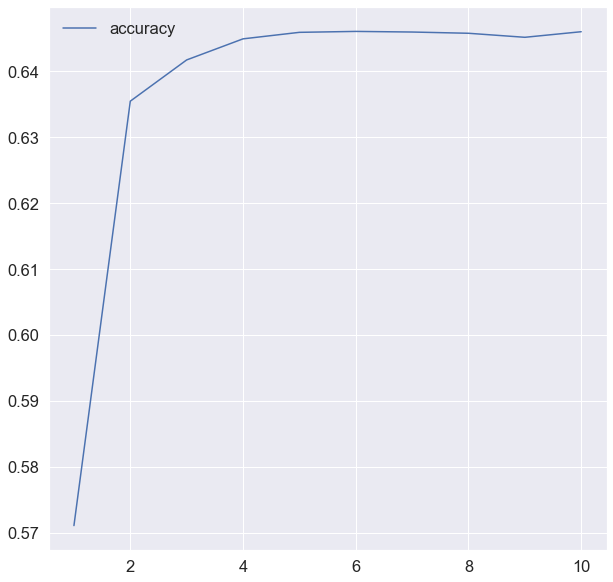

In [20]:
accuracy_list = []
for i in range (1,11):
    vect_optimum = CountVectorizer(min_df=5, ngram_range=(1,i)).fit(x_train.remarks)
    vectorized_optimum = vect_optimum.transform(x_train.remarks)
    naive_model_optimum = MultinomialNB().fit(vectorized_optimum, y_train)
    pred_optimum = naive_model_optimum.predict(vect_optimum.transform(x_test.remarks))
    accuracy_list.append(metrics.accuracy_score(y_test, pred_optimum))

matplotlib.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = [10, 10] 
sns.set(font_scale=1.5)
pd.DataFrame({"accuracy": accuracy_list}, index=range(1,11)).plot.line()

A significant increase is shown when bigram is added, 4-gram and 5-gram add insignificant increase to the accuracy, While 6-gram above reduces the accuracy. Using 4-gram maximizes our accuracy.

#### *Generate 5-gram from remarks*

In [21]:
vect_5gram = CountVectorizer(min_df=5, ngram_range=(1,5)).fit(x_train.remarks)

vect_5gram.get_feature_names_out()

array(['aa', 'aa florist', 'aan', ..., 'zz meeting id',
       'zz meeting id passcode', 'zz meeting id passcode hpam'],
      dtype=object)

<pre>
Examples of N-grams:
    1-gram  : "aa"
    2-gram  : "aa florist"
    3-gram  : "zz meeting id"
    4-gram  : "zz meeting id passcode"
    5-gram  : "zz meeting id passcode aa"
</pre>

#### *Naive bayes model*

In [22]:
model_naive_target = MultinomialNB()
model_naive_target.fit(vect_5gram.transform(x_train.remarks), y_train)

MultinomialNB()

#### *Save model into a pickle data*

In [23]:
pickle.dump(model_naive_target, open("ML_Model/Naive_Target_Model.sav", "wb"))
pickle.dump(vect_5gram, open("ML_Model/Naive_Target_Vectorizer.sav", "wb"))

#### *Prediction*

In [24]:
pred_5gram = model_naive_target.predict(vect_5gram.transform(x_test.remarks))

print("Classification Report")
print("===========================")
print("Accuracy", metrics.accuracy_score(y_test, pred_5gram))
print("===========================\n")
print(metrics.classification_report(y_test, pred_5gram, labels=y_train.sort_values().unique()))

Classification Report
Accuracy 0.6458783720274461

              precision    recall  f1-score   support

           3       0.76      0.69      0.72      4361
           4       0.73      0.73      0.73      7610
           5       0.65      0.58      0.62      5337
           6       0.44      0.58      0.50      2489
           7       0.40      0.53      0.46      1014
           8       0.21      0.22      0.21       253
           9       0.33      0.09      0.15       150
          10       1.00      0.07      0.14        40
          11       0.00      0.00      0.00        17
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         2

   micro avg       0.65      0.65      0.65     21276
   macro avg       0.41      0.32      0.32     21276
weighted avg       0.66      0.65      0.65     21276



#### *Confusion matrix*

Text(88.14000000000001, 0.5, 'predicted label')

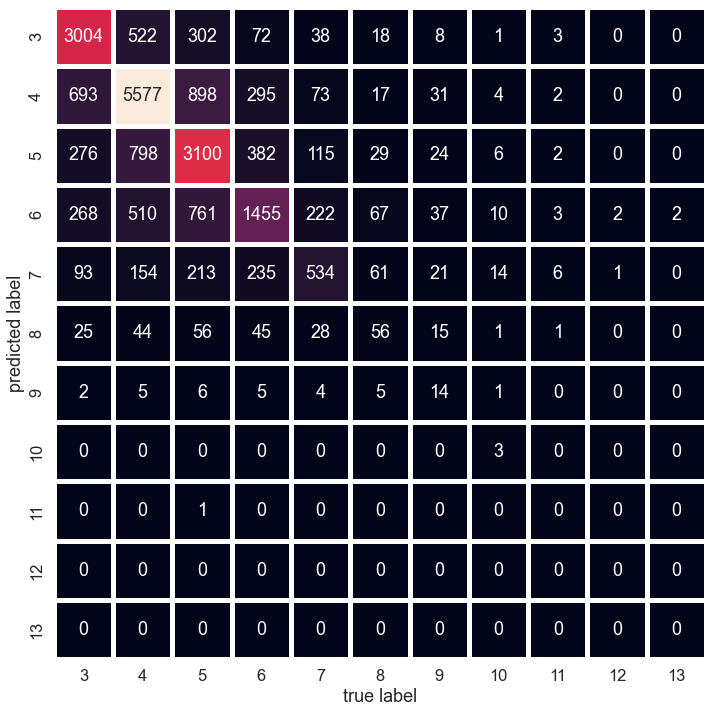

In [25]:
cm = metrics.confusion_matrix(y_test, pred_5gram, labels=y_train.sort_values().unique())
plt.rcParams["figure.figsize"] = [12, 12]
sns.set(font_scale=1.5)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False, linewidth=5,
            xticklabels=y_train.sort_values().unique(), yticklabels=y_train.sort_values().unique())
plt.xlabel('true label')
plt.ylabel('predicted label')

Things to try:

 - grouping by sum of ttc, cxy, and rps
 - text processing
 - Accuracy line chart for 1-10 grams to see which method perform the best

## Score prediction per target

After we are done with predicting target point created from calculating a total of three parameters available in the data, the next step would be to determine the score of each remarks written inside the dataframe. Some might be wondering why should we create two layer of machine learning prediction like this. With a total of 15 target, we only managed to get the accuracy of 64.24%, and each target contain certain range of score. For example, target 3 have a range of score of 1-4. Further more, the score went up to 100 point. As of now, there were not enough data to train our model to predict as much as 100 target.

<AxesSubplot:xlabel='target', ylabel='count'>

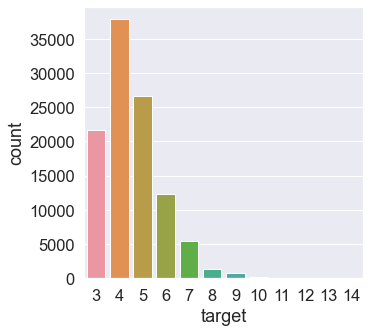

In [26]:
plt.rcParams["figure.figsize"] = [5, 5]
sns.countplot(proms_data.target)

To make it worse, The distribution of the data is not distributed evenly at all as there are a huge gap between target. All the more reason that we should create a separate machine learning for each target. For demonstration, I will show the data that are in the category of target 4.

#### *Obtain data that falls in category of target 4*

In [27]:
proms_target_3 = proms_data.loc[proms_data.target == 3]
proms_target_4 = proms_data.loc[proms_data.target == 4]
proms_target_5 = proms_data.loc[proms_data.target == 5]
proms_target_6 = proms_data.loc[proms_data.target == 6]
proms_target_7 = proms_data.loc[proms_data.target == 7]
proms_target_8 = proms_data.loc[proms_data.target == 8]
proms_target_9 = proms_data.loc[proms_data.target == 9]
proms_target_10 = proms_data.loc[proms_data.target == 10]

proms_target_4.head()

,title,remarks,time_to_completion,complexity,related_parties,score,created_at,office,division,word_count,target
5,kirim nav hari ke nasabah,nav kirim rutin tiap hari,1,1,2,5.0,2021-01-05T17:42:01.000000Z,"Tamara, Jakarta",Fund Administration & Operasional,5,4
6,kirim nav hari ke nasabah,kirim nav hari rutin ke nasabah,1,1,2,5.0,2021-01-05T17:42:56.000000Z,"Tamara, Jakarta",Fund Administration & Operasional,6,4
7,laku rekap mutasi rekening reksa dana bulan,rekap mutasi rekening tampung bca bri niaga ma...,1,2,1,5.0,2021-01-05T17:44:42.000000Z,"Tamara, Jakarta",Fund Administration & Operasional,5,4
8,kirim instruksi bayar iklan ke bk,kirim surat instruksi bayar iklan umum adendum...,1,1,2,5.0,2021-01-05T17:47:29.000000Z,"Tamara, Jakarta",Fund Administration & Operasional,13,4
13,retur redemption atas nama cynthia putri,jalan kembali dana retur atas nama cynthia put...,1,1,2,5.0,2021-01-06T07:35:16.000000Z,"Tamara, Jakarta",Fund Administration & Operasional,13,4


#### *Check for noise in our data*

In [28]:
proms_target_4.score.sort_values().unique()

array([ 1.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 13.])

In [29]:
proms_target_3 = proms_target_3.loc[(proms_target_3.score >= 1) & (proms_target_3.score <= 4)]
proms_target_4 = proms_target_4.loc[(proms_target_4.score >= 5) & (proms_target_4.score <= 8)]
proms_target_5 = proms_target_5.loc[(proms_target_5.score >= 9) & (proms_target_5.score <= 12)]
proms_target_6 = proms_target_6.loc[(proms_target_6.score >= 13) & (proms_target_6.score <= 16)]
proms_target_7 = proms_target_7.loc[(proms_target_7.score >= 17) & (proms_target_7.score <= 22)]
proms_target_8 = proms_target_8.loc[(proms_target_8.score >= 23) & (proms_target_8.score <= 28)]
proms_target_9 = proms_target_9.loc[(proms_target_9.score >= 29) & (proms_target_9.score <= 34)]
proms_target_10 = proms_target_10.loc[(proms_target_10.score >= 35) & (proms_target_10.score <= 43)]

proms_target_4.head()

,title,remarks,time_to_completion,complexity,related_parties,score,created_at,office,division,word_count,target
5,kirim nav hari ke nasabah,nav kirim rutin tiap hari,1,1,2,5.0,2021-01-05T17:42:01.000000Z,"Tamara, Jakarta",Fund Administration & Operasional,5,4
6,kirim nav hari ke nasabah,kirim nav hari rutin ke nasabah,1,1,2,5.0,2021-01-05T17:42:56.000000Z,"Tamara, Jakarta",Fund Administration & Operasional,6,4
7,laku rekap mutasi rekening reksa dana bulan,rekap mutasi rekening tampung bca bri niaga ma...,1,2,1,5.0,2021-01-05T17:44:42.000000Z,"Tamara, Jakarta",Fund Administration & Operasional,5,4
8,kirim instruksi bayar iklan ke bk,kirim surat instruksi bayar iklan umum adendum...,1,1,2,5.0,2021-01-05T17:47:29.000000Z,"Tamara, Jakarta",Fund Administration & Operasional,13,4
13,retur redemption atas nama cynthia putri,jalan kembali dana retur atas nama cynthia put...,1,1,2,5.0,2021-01-06T07:35:16.000000Z,"Tamara, Jakarta",Fund Administration & Operasional,13,4


#### *Train and test split*

In [30]:
x3_train, x3_test, y3_train, y3_test = train_test_split(proms_target_3.loc[:, proms_target_3.columns != "score"], 
proms_target_3.score, test_size=0.2, random_state=126)

x4_train, x4_test, y4_train, y4_test = train_test_split(proms_target_4.loc[:, proms_target_4.columns != "score"], 
proms_target_4.score, test_size=0.2, random_state=126)

x5_train, x5_test, y5_train, y5_test = train_test_split(proms_target_5.loc[:, proms_target_5.columns != "score"], 
proms_target_5.score, test_size=0.2, random_state=126)

x6_train, x6_test, y6_train, y6_test = train_test_split(proms_target_6.loc[:, proms_target_6.columns != "score"], 
proms_target_6.score, test_size=0.2, random_state=126)

x7_train, x7_test, y7_train, y7_test = train_test_split(proms_target_7.loc[:, proms_target_7.columns != "score"], 
proms_target_7.score, test_size=0.2, random_state=126)

x8_train, x8_test, y8_train, y8_test = train_test_split(proms_target_8.loc[:, proms_target_8.columns != "score"], 
proms_target_8.score, test_size=0.2, random_state=126)

x9_train, x9_test, y9_train, y9_test = train_test_split(proms_target_9.loc[:, proms_target_9.columns != "score"], 
proms_target_9.score, test_size=0.2, random_state=126)

x10_train, x10_test, y10_train, y10_test = train_test_split(proms_target_10.loc[:, proms_target_10.columns != "score"], 
proms_target_10.score, test_size=0.2, random_state=126)

#### *Naive Bayes model*

In [31]:
vect_3 = CountVectorizer(min_df=5, ngram_range=(1,5)).fit(x3_train.remarks)
vectorized_3 = vect_3.transform(x3_train.remarks)
model_naive_3 = MultinomialNB()
model_naive_3.fit(vectorized_3, y3_train)

vect_4 = CountVectorizer(min_df=5, ngram_range=(1,5)).fit(x4_train.remarks)
vectorized_4 = vect_4.transform(x4_train.remarks)
model_naive_4 = MultinomialNB()
model_naive_4.fit(vectorized_4, y4_train)

vect_5 = CountVectorizer(min_df=5, ngram_range=(1,5)).fit(x5_train.remarks)
vectorized_5 = vect_5.transform(x5_train.remarks)
model_naive_5 = MultinomialNB()
model_naive_5.fit(vectorized_5, y5_train)

vect_6 = CountVectorizer(min_df=5, ngram_range=(1,5)).fit(x6_train.remarks)
vectorized_6 = vect_6.transform(x6_train.remarks)
model_naive_6 = MultinomialNB()
model_naive_6.fit(vectorized_6, y6_train)

vect_7 = CountVectorizer(min_df=5, ngram_range=(1,5)).fit(x7_train.remarks)
vectorized_7 = vect_7.transform(x7_train.remarks)
model_naive_7 = MultinomialNB()
model_naive_7.fit(vectorized_7, y7_train)

vect_8 = CountVectorizer(min_df=5, ngram_range=(1,5)).fit(x8_train.remarks)
vectorized_8 = vect_8.transform(x8_train.remarks)
model_naive_8 = MultinomialNB()
model_naive_8.fit(vectorized_8, y8_train)

vect_9 = CountVectorizer(min_df=5, ngram_range=(1,5)).fit(x9_train.remarks)
vectorized_9 = vect_9.transform(x9_train.remarks)
model_naive_9 = MultinomialNB()
model_naive_9.fit(vectorized_9, y9_train)

vect_10 = CountVectorizer(min_df=5, ngram_range=(1,5)).fit(x10_train.remarks)
vectorized_10 = vect_10.transform(x10_train.remarks)
model_naive_10 = MultinomialNB()
model_naive_10.fit(vectorized_10, y10_train)

MultinomialNB()

#### *Save model*

In [32]:
pickle.dump(model_naive_3, open("ML_Model/Naive_3_Model.sav", "wb"))
pickle.dump(vect_3, open("ML_Model/Naive_3_Vectorizer.sav", "wb"))

pickle.dump(model_naive_4, open("ML_Model/Naive_4_Model.sav", "wb"))
pickle.dump(vect_4, open("ML_Model/Naive_4_Vectorizer.sav", "wb"))

pickle.dump(model_naive_5, open("ML_Model/Naive_5_Model.sav", "wb"))
pickle.dump(vect_5, open("ML_Model/Naive_5_Vectorizer.sav", "wb"))

pickle.dump(model_naive_6, open("ML_Model/Naive_6_Model.sav", "wb"))
pickle.dump(vect_6, open("ML_Model/Naive_6_Vectorizer.sav", "wb"))

pickle.dump(model_naive_7, open("ML_Model/Naive_7_Model.sav", "wb"))
pickle.dump(vect_7, open("ML_Model/Naive_7_Vectorizer.sav", "wb"))

pickle.dump(model_naive_8, open("ML_Model/Naive_8_Model.sav", "wb"))
pickle.dump(vect_8, open("ML_Model/Naive_8_Vectorizer.sav", "wb"))

pickle.dump(model_naive_9, open("ML_Model/Naive_9_Model.sav", "wb"))
pickle.dump(vect_9, open("ML_Model/Naive_9_Vectorizer.sav", "wb"))

pickle.dump(model_naive_10, open("ML_Model/Naive_10_Model.sav", "wb"))
pickle.dump(vect_10, open("ML_Model/Naive_10_Vectorizer.sav", "wb"))

#### *Prediction*

In [33]:
pred_3 = model_naive_3.predict(vect_3.transform(x3_test.remarks))
pred_4 = model_naive_4.predict(vect_4.transform(x4_test.remarks))
pred_5 = model_naive_5.predict(vect_5.transform(x5_test.remarks))
pred_6 = model_naive_6.predict(vect_6.transform(x6_test.remarks))
pred_7 = model_naive_7.predict(vect_7.transform(x7_test.remarks))
pred_8 = model_naive_8.predict(vect_8.transform(x8_test.remarks))
pred_9 = model_naive_9.predict(vect_9.transform(x9_test.remarks))
pred_10 = model_naive_10.predict(vect_10.transform(x10_test.remarks))

In [34]:
print("Accuracy of target 3:    ", metrics.accuracy_score(y3_test, pred_3))
print("Accuracy of target 4:    ", metrics.accuracy_score(y4_test, pred_4))
print("Accuracy of target 5:    ", metrics.accuracy_score(y5_test, pred_5))
print("Accuracy of target 6:    ", metrics.accuracy_score(y6_test, pred_6))
print("Accuracy of target 7:    ", metrics.accuracy_score(y7_test, pred_7))
print("Accuracy of target 8:    ", metrics.accuracy_score(y8_test, pred_8))
print("Accuracy of target 9:    ", metrics.accuracy_score(y9_test, pred_9))
print("Accuracy of target 10:  ", metrics.accuracy_score(y10_test, pred_10))

Accuracy of target 3:     0.684259045863102
Accuracy of target 4:     0.7983304624354048
Accuracy of target 5:     0.665913796348579
Accuracy of target 6:     0.6990251827782291
Accuracy of target 7:     0.6512488436632747
Accuracy of target 8:     0.5634328358208955
Accuracy of target 9:     0.5408805031446541
Accuracy of target 10:   0.6216216216216216


In [44]:
print("Classification Report")
print("===========================")
print("Accuracy", metrics.accuracy_score(y4_test, pred_4))
print("===========================\n")
print(metrics.classification_report(y4_test, pred_4, labels=y4_train.sort_values().unique()))

Classification Report
Accuracy 0.7983304624354048

              precision    recall  f1-score   support

         5.0       0.87      0.86      0.86      4293
         6.0       0.84      0.80      0.82      2052
         7.0       0.35      0.46      0.40       231
         8.0       0.56      0.61      0.58       971

    accuracy                           0.80      7547
   macro avg       0.65      0.68      0.67      7547
weighted avg       0.81      0.80      0.80      7547



#### *Confusion Matrix*

Text(20.1, 0.5, 'predicted label')

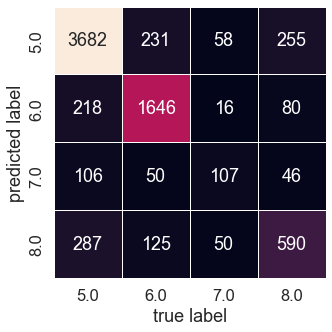

In [ ]:
cm = metrics.confusion_matrix(y4_test, pred_4, labels=y4_train.sort_values().unique())
plt.rcParams["figure.figsize"] = [5, 5]
sns.set(font_scale=1.5)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False, linewidths=0.5,
            xticklabels=y4_train.sort_values().unique(), yticklabels=y4_train.sort_values().unique())
plt.xlabel('true label')
plt.ylabel('predicted label')

## Division prediction

#### *Division performance*

In [ ]:
proms_data.groupby("division").agg({"score": "sum"}).sort_values("score", ascending=False)

,score
division,
Marketing Ritel,346702.0
Non-Retail Investment Advisory,81126.0
Fund Administration & Operasional,77905.0
Business Development & Marketing Communications,62085.0
Strategy & Tactical Allocation,53171.0
Accounting & Tax,49434.0
"Retail, Product Research & Distributions",46009.0
IT System,33681.0
Finance & Budget,32495.0


#### *Train and test split*

In [ ]:
xdiv_train, xdiv_test, ydiv_train, ydiv_test = train_test_split(proms_data.loc[:, proms_data.columns != "score"], 
proms_data.division, test_size=0.2, random_state=126)

#### *Naive Bayes modeling*

In [ ]:
vect_div = CountVectorizer(min_df=5, ngram_range=(1,5)).fit(xdiv_train.remarks)

vectorized_div = vect_div.transform(xdiv_train.remarks)

model_naive_div = MultinomialNB()
model_naive_div.fit(vectorized_div, ydiv_train)

MultinomialNB()

In [ ]:
pickle.dump(model_naive_div, open("ML_Model/Naive_Division_Model.sav", "wb"))
pickle.dump(vect_div, open("ML_Model/Naive_Division_Vectorizer.sav", "wb"))

In [ ]:
model = pickle.load(open("ML_Model/Naive_Division_Model.sav", "rb"))
vectorizer = pickle.load(open("ML_Model/Naive_Division_Vectorizer.sav", "rb"))

model.predict(vectorizer.transform([xdiv_test.remarks.tolist()[0]]))

array(['Business Development & Marketing Communications'], dtype='<U47')

In [ ]:
pred_div = model_naive_div.predict(vect_div.transform(xdiv_test.remarks))

print("Classification Report")
print("===========================")
print("Accuracy", metrics.accuracy_score(ydiv_test, pred_div))
print("===========================\n")
print(metrics.classification_report(ydiv_test, pred_div, labels=ydiv_train.sort_values().unique()))

Classification Report
Accuracy 0.8753172290628819

                                                 precision    recall  f1-score   support

                               Accounting & Tax       0.92      0.83      0.87       866
Business Development & Marketing Communications       0.69      0.88      0.77      1508
                Digital Marketing Communication       0.68      0.33      0.44        83
                        Execution & Proprietary       0.97      0.63      0.77       334
                               Finance & Budget       0.84      0.87      0.86       891
              Fund Administration & Operasional       0.93      0.91      0.92      1409
                      Human Capital Development       0.67      0.85      0.75       393
                                      IT System       0.86      0.91      0.89      1224
                       Internal Audit and Legal       0.71      0.79      0.75       273
   Kepatuhan, Manajemen Risiko, Produk, APU PPT       0.84

Text(73.65312499999999, 0.5, 'predicted label')

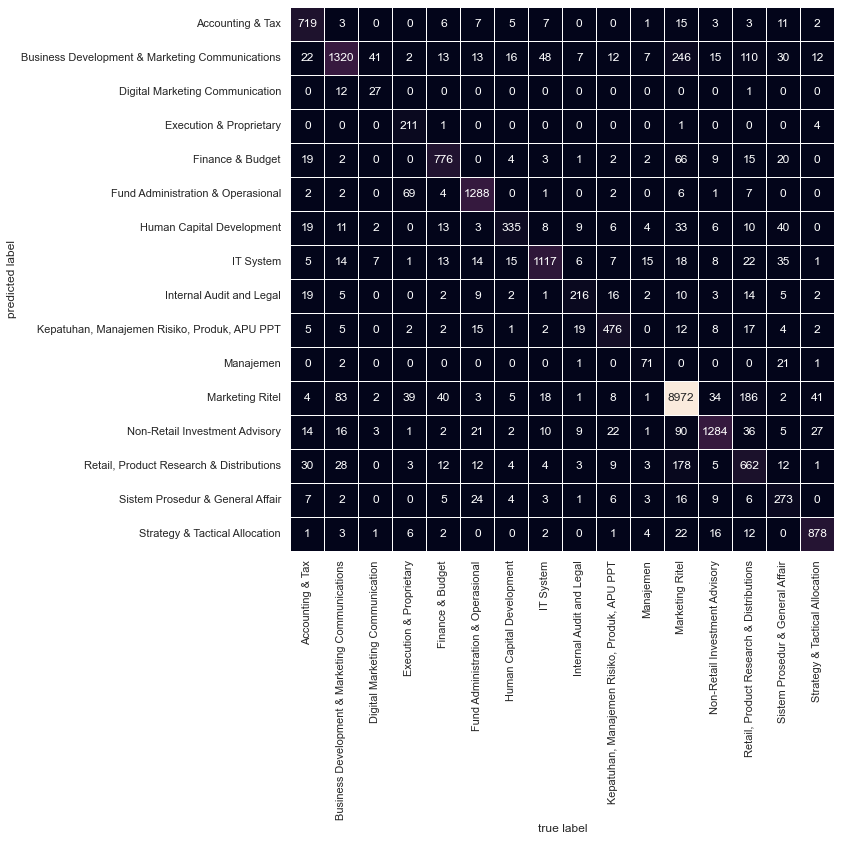

In [ ]:
cm = metrics.confusion_matrix(ydiv_test, pred_div, labels=ydiv_train.sort_values().unique())
plt.rcParams["figure.figsize"] = [10, 10]
sns.set(font_scale=1)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False, linewidths=0.5,
            xticklabels=ydiv_train.sort_values().unique(), yticklabels=ydiv_train.sort_values().unique())
plt.xlabel('true label')
plt.ylabel('predicted label')